# Introduction

## The Project

Over the past several months, a friend of mine has been developing a fully automated hydroponic vertical farm prototype in his Gold Coast apartment, with the intention to set up an operational system in the basement of his family home in the north suburbs of Chicago, where he will grow microgreens for sale to local restaurants and grocers. As this project involves large amounts of raw data, he has asked for my help with data processing and analysis. 

At the time the data used here was collected, the system's main component was a 20 gallon plastic tub which was filled about halfway with water. Plants have not yet been introduced. The data includes readings from sensors measuring pH, Conductivity, Water Temperature, Room Temperature, and Humidity. Also included is several pumps which handle dosing the water bath with various additives, namely pH Up, pH Down, and a premade Nutrient Mix. Several fans are also included in the IoT network, but those do not factor into the work done in this notebook.

## The Problem

When it comes time to grow plants, the nutrients they are provided with will need to be closely managed. While there isn't an easy way to measure these nutrients directly, any nutrient compounds dissolved in water take the form of ions, which inherently add to the solution's **conductivity**. This allows us to use the conductivity as a proxy measurement for estimating nutrient levels in the solution. However, the pH Up additive (and the pH Down, to a lesser extent) also contributes ions that increase the conductivity of the solution. This analysis aims to characterize the contribution of the pH Up and Nutrient Mix additives to the system's conductivity through the use of the experimental data described below. 

While not in the scope of this notebook, the final goal is to have the server layer of this system make decisions of when and how much to dose with Nutrient Mix informed by live data.

## The Data

To solve this problem, we designed and executed a handful of experiments. There were several weeks between the first of these experiments and the rest, during which time the system and data pipeline were improved, resulting in two distinct data structures for pipelining. The experiments, and their structures, are as follows:
- Exp. 0
    - Tap water 
    - pH unadjusted prior to beginning
    - pH Up added in consistent volume at irregular intervals (dosage order triggered manually)
    - Nutrient Mix not added
    - Raw data is in two line-by-line text files, where each line is one report from one IoT component; saved as csv and read by Python
- Exp. 1-3
    - Tap water
    - pH adjusted with pH Down to the bottom of the expected operating range (~6) prior to beginning
    - pH Up and Nutrient Mix added in consistent volume at consistent, alternating intervals (dosage schedule automated)
    - Raw data is rectangular but untidy, saved as csv and read by Python
    
These experiments, while crude, allow us to begin analyzing the relationship between these additives and the conductivity as well as the other solution properties measured and reported by the IoT network. A more robust analysis will be taken up once the system is operational in its final location and planted with crop.

# Pre-Processing

In [1]:
# import packages used in pre-processing
import pandas as pd
import numpy as np

pd.set_option('display.float_format', lambda x: '%.4f' % x)

## Preliminary Tidying

### Experiment 0: Raw Text Data

The data streams for this project include sensors that measure and report the temperature, pH, and conductivity of the hydroponic system, as well as the status of the pumps and fans that control the system. These streams are received in multiple feeds of one-dimensional text data, which must be parsed, interpreted, and tidied before any analysis can be done. The data streams from two separate feeds, labeled "ESP32" and "Arduino". The first step is to combine them into a single DataFrame object.

In [2]:
# read raw data to dict of dataframe objects, then concatenate them together
file = 'pHDoseUpExperiment_12142022.xls'
raw_data = pd.read_excel(file, sheet_name=None, header=None)
raw_data = pd.concat([raw_data['ESP32'], raw_data['Arduino']])
display(raw_data.head())

,0
0,12/10/2022 13:45:45.133 -> Water Temp: 28.50
1,12/10/2022 13:45:50.150 -> Water Temp: 28.50
2,12/10/2022 13:45:55.163 -> Water Temp: 28.50
3,12/10/2022 13:45:58.926 -> <Relay:0:0:0>
4,12/10/2022 13:46:00.134 -> Water Temp: 28.50


Both feeds exhibit the format of `"{timestamp}->{value}"`; the `value` portion is inconsistent between all the sensors, but the timestamp can be parsed out easily using the `->` string as a delimiter. 

In [3]:
data = raw_data.iloc[:,0].str.split('->', expand=True)
data.columns = 'Time', 'Reading'
display(data.head())

,Time,Reading
0,12/10/2022 13:45:45.133,Water Temp: 28.50
1,12/10/2022 13:45:50.150,Water Temp: 28.50
2,12/10/2022 13:45:55.163,Water Temp: 28.50
3,12/10/2022 13:45:58.926,<Relay:0:0:0>
4,12/10/2022 13:46:00.134,Water Temp: 28.50


Next, we define a function to be applied row-wise to the dataframe which will parse and interpret the different sensor and pump outputs based on their specific patterns and ID codes. In particular, the ID codes for the rows with the "Relay" tag follow the pattern *X:Y:Z* where *X:Y* can be used to identify the relay, and *Z* is the binary value reporting the state of the relay.  

Additionally, several types of readings which carry no useful information are now filtered out.

In [4]:
def process_row(row):
    '''
    Function for use with pd.apply(). Parses sensor outputs into
    Measurement and Value.
    '''
    
    # parse and clean up the reported reading
    measurement, value = row.Reading.split(':', 1)
    measurement = measurement.strip(' <')
    value = value.strip('>')
    
    # store relay codes in dict
    relay_ids = {
        '0:0': 'Mix Pump',
        '0:1': 'Main Pump',
        '1:0': 'Mixing Fan'
    }
    
    # interpret relay codes, where present
    if measurement == 'Relay':
        relay = relay_ids[value[:3]]
        measurement = relay
        value = value[-1]
    
    # parse Dosing measurement, with its unique format
    elif measurement == 'Dosing':
        value = value.split(':')[1]
    
    # filter out unwanted readings
    if measurement in ('Received Chars', 'CMD', 'Channel', '') or value == '':
        return np.nan, np.nan, np.nan # returning a row of NaNs allows us to drop these rows instantly using .dropna()
    
    # return parsed row
    else:
        return [row.Time, measurement, value]

    
# apply new fucntion row-wise, dropping unwanted rows and resetting index to account for those dropped
data = data.apply(process_row, axis=1, result_type='expand').dropna().reset_index(drop=True)
data.columns = 'Time', 'Measurement', 'Value'

# recast to proper dtypes
data = data.astype(
    {
        'Time': np.datetime64,
        'Value': float
    }
)

display(data.head())
print(data.Measurement.unique())

,Time,Measurement,Value
0,2022-12-10 13:45:45.133,Water Temp,28.5000
1,2022-12-10 13:45:50.150,Water Temp,28.5000
2,2022-12-10 13:45:55.163,Water Temp,28.5000
3,2022-12-10 13:45:58.926,Mix Pump,0.0000
4,2022-12-10 13:46:00.134,Water Temp,28.5000


['Water Temp' 'Mix Pump' 'Main Pump' 'Mixing Fan' 'Dosing' 'PH'
 'Scale Reading' 'EC']


Now that everything is parsed, we can apply the `pivot_table` DataFrame method, specifying `columns='Measurement', values='Value', 'index='Time'` so that all of the different sensors, pumps, and fans in the `Measurement` field get their own column that is populated with the `Value` of that measurement at a given `Time`, which is set as the index.

In [5]:
# pivot so measurements are columns
data1 = data.pivot_table(columns='Measurement', values='Value', index='Time')

# rename semantically irritating columns
data1.rename(columns={'Dosing':'pH_Up_Dosing',
                     'EC': 'Conductivity',
                     'PH': 'pH'}, inplace=True)

# add cumulative dosing column
data1['cumulative_ph_up'] = data1['pH_Up_Dosing'].cumsum().fillna(method='ffill').fillna(0)
data1['cumulative_nutrient_mix'] = 0

display(data1.head())
display(data1.info())

Measurement,pH_Up_Dosing,Conductivity,Main Pump,Mix Pump,Mixing Fan,pH,Scale Reading,Water Temp,cumulative_ph_up,cumulative_nutrient_mix
Time,,,,,,,,,,
2022-12-10 13:45:45.133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.5000,0.0000,0
2022-12-10 13:45:46.169,NaN,NaN,NaN,NaN,NaN,7.5180,NaN,NaN,0.0000,0
2022-12-10 13:45:46.685,NaN,NaN,NaN,NaN,NaN,NaN,72.0400,NaN,0.0000,0
2022-12-10 13:45:50.150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.5000,0.0000,0
2022-12-10 13:45:51.141,NaN,355.9000,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21203 entries, 2022-12-10 13:45:45.133000 to 2022-12-11 00:18:39.827000
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   pH_Up_Dosing             34 non-null     float64
 1   Conductivity             3481 non-null   float64
 2   Main Pump                119 non-null    float64
 3   Mix Pump                 335 non-null    float64
 4   Mixing Fan               107 non-null    float64
 5   pH                       3482 non-null   float64
 6   Scale Reading            6181 non-null   float64
 7   Water Temp               7596 non-null   float64
 8   cumulative_ph_up         21203 non-null  float64
 9   cumulative_nutrient_mix  21203 non-null  int64  
dtypes: float64(9), int64(1)
memory usage: 1.8 MB


None

That's enough for this dataset for now - we will return after we do some work on the remaining data.

### Experiments 1-3: Untidy Rectangular Data

As this data has already been parsed into tabular format, we don't need to do too much to prepare it for concatenation with the first experiment's data.  

To start, the column names have unnecessary prefixes that can be elegantly handled with a regex replacement.

In [6]:
# read in raw data
data2 = pd.read_csv('Dosing Experiment - Feb 2023.csv')
display(data2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65472 entries, 0 to 65471
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   local_time                            65472 non-null  object 
 1   input_number.cumulative_nutrient_mix  65472 non-null  float64
 2   input_number.cumulative_ph_up         65472 non-null  float64
 3   input_number.target_ph                65472 non-null  float64
 4   input_text.dosing_log                 65472 non-null  object 
 5   input_text.experiment_name            65472 non-null  object 
 6   input_text.raw_name                   65472 non-null  object 
 7   sensor.atlas_ec                       65472 non-null  float64
 8   sensor.atlas_ph                       65414 non-null  float64
 9   sensor.cpu_temperature                65472 non-null  float64
 10  sensor.humidity                       65472 non-null  float64
 11  sensor.room_tem

None

In [7]:
# remove unnecessary column prefixes
data2.columns = data2.columns.str.replace('.*\.', '', regex=True)
display(data2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65472 entries, 0 to 65471
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   local_time               65472 non-null  object 
 1   cumulative_nutrient_mix  65472 non-null  float64
 2   cumulative_ph_up         65472 non-null  float64
 3   target_ph                65472 non-null  float64
 4   dosing_log               65472 non-null  object 
 5   experiment_name          65472 non-null  object 
 6   raw_name                 65472 non-null  object 
 7   atlas_ec                 65472 non-null  float64
 8   atlas_ph                 65414 non-null  float64
 9   cpu_temperature          65472 non-null  float64
 10  humidity                 65472 non-null  float64
 11  room_temp                65472 non-null  float64
 12  water_amount             65472 non-null  float64
 13  water_temp               65472 non-null  float64
 14  relay_8ch_0           

None

Next, we rename a handful of columns that we want to match with the previously prepared dataframe. Then we recast the `Time` variable as a timestamp and set it to the index.

In [8]:
# rename irritating, unclear, or mismatching columns
data2.rename(inplace=True, columns={
    'local_time': 'Time',
    'atlas_ec': 'Conductivity',
    'atlas_ph': 'pH',
    'water_temp': 'Water Temp'
    }
)

# recast time as datetime dtype
data2 = data2.astype({'Time': np.datetime64})

# set timestamp as the index
data2.set_index('Time', inplace=True)
display(data2)

,cumulative_nutrient_mix,cumulative_ph_up,target_ph,dosing_log,experiment_name,raw_name,Conductivity,pH,cpu_temperature,humidity,room_temp,water_amount,Water Temp,relay_8ch_0,relay_8ch_1,relay_8ch_2,relay_8ch_3
Time,,,,,,,,,,,,,,,,,
2023-02-13 16:46:06,0.0000,0.0000,5.7500,0,"Experiment 1 - 2023.02.13 - Up: 30mL, Nute Ini...","Experiment 1 - 2023.02.13 - Up: 30mL, Nute Ini...",407.8000,5.8170,43.3000,51.6000,21.7000,14.2000,24.9400,1,0,0,0
2023-02-13 16:46:06,0.0000,0.0000,5.7500,0,"Experiment 1 - 2023.02.13 - Up: 30mL, Nute Ini...",0,407.8000,5.8170,43.3000,51.6000,21.7000,14.2000,24.9400,1,0,0,0
2023-02-13 16:46:06,0.0000,0.0000,5.7500,0,"Experiment 1 - 2023.02.13 - Up: 30mL, Nute Ini...",0,407.8000,5.8170,43.3000,51.6000,21.7000,13.4000,24.9400,1,0,0,0
2023-02-13 16:46:07,0.0000,0.0000,5.7500,0,"Experiment 1 - 2023.02.13 - Up: 30mL, Nute Ini...",0,407.8000,5.8170,43.3000,51.6000,21.7000,13.4000,25.0000,1,0,0,0
2023-02-13 16:46:08,0.0000,0.0000,5.7500,0,"Experiment 1 - 2023.02.13 - Up: 30mL, Nute Ini...",0,407.3000,5.8170,43.3000,51.6000,21.7000,13.4000,25.0000,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-16 17:59:23,570.0000,570.0000,5.6500,0,"Experiment 2 Cont'd - Wifi was actin the fool,...",0,925.9000,6.9950,41.9000,52.9000,21.1000,17.6000,23.0000,0,0,0,0
2023-02-16 17:59:23,570.0000,570.0000,5.6500,0,"Experiment 2 Cont'd - Wifi was actin the fool,...",0,925.9000,6.9950,41.9000,52.9000,21.1000,17.6000,23.0600,0,0,0,0
2023-02-16 17:59:24,570.0000,570.0000,5.6500,0,"Experiment 2 Cont'd - Wifi was actin the fool,...",0,925.9000,6.9770,41.9000,52.9000,21.1000,17.6000,23.0600,0,0,0,0


The `dosing_log` variable contains the information for all dosing events for every additive. Below we define a function to apply row-wise to interpret this columns.

In [9]:
# function to interpret the dosing log column, which details the addition
## of all solutions of interest
def interpret_dosing_log(row):
    # format is pump# : dose volume (mL) : pump speed
    # 0 is pH Up
    # 1 is pH Down
    # 2 is Nutrient Mix
    # 3 will be peroxide
    dosing_ids = {0: 'pH_Up_Dosing',
                  1: 'pH_Down_Dosing',
                  2: 'Nutrient_Mix_Dosing',
                  3: 'Hydrogen_Peroxide_Dosing'}
    
    # conveniently, all present invalid values are convertible to float, while valid values are not
    ## try/except is a nifty way to filter these out.
    ## invalid entries represent no dose; the exceptions are valid entries
    try: 
        float(row.dosing_log)
    except:
        dosing_id = int(row.dosing_log.split(':')[1])
        dosing_volume = float(row.dosing_log.split(':')[2])
        dosing_substance = dosing_ids[dosing_id]
        row[dosing_substance] = dosing_volume
        
    return row


# applying the function
data2 = data2.apply(interpret_dosing_log, axis=1, result_type='expand')
display(data2.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 65472 entries, 2023-02-13 16:46:06 to 2023-02-16 17:59:28
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Conductivity              65472 non-null  float64
 1   Hydrogen_Peroxide_Dosing  8 non-null      float64
 2   Nutrient_Mix_Dosing       71 non-null     float64
 3   Water Temp                65472 non-null  float64
 4   cpu_temperature           65472 non-null  float64
 5   cumulative_nutrient_mix   65472 non-null  float64
 6   cumulative_ph_up          65472 non-null  float64
 7   dosing_log                65472 non-null  object 
 8   experiment_name           65472 non-null  object 
 9   humidity                  65472 non-null  float64
 10  pH                        65414 non-null  float64
 11  pH_Down_Dosing            60 non-null     float64
 12  pH_Up_Dosing              71 non-null     float64
 13  raw_name                  

None

## Concatenating & Downsampling

The final step before concatenating the dataframes is to parse the `experiment_name` column which includes the ID number of each experiment, which will be useful during EDA. Some of the experiments with the same number were not strictly continuous, so these were renumbered to be distinct experiments. Additionally, we add the `experiment_number` to the dataframe from the first experiment and set it to `0`.

In [10]:
# parse exp number from name
## previously processed data gets exp number of 0
data1['experiment_number'] = 0
data2['experiment_number'] = data2.experiment_name.str[11].astype(int)

# renumber experiments such that each experiment is continuous
data2.loc[data2.experiment_number == 2, 'experiment_number'] = 3
data2.loc['2023-02-14', 'experiment_number'] = 2

Finally, we can combine these dataframes using `pd.concat()`. We also take this opportunity to discard any non-numeric data so we can downsample the data to intervals of 30 seconds, using the means to aggregate. Because the data is non-continuous, this results in several weeks' worth of `NaN` rows, which are dropped. 

In [11]:
data_all = pd.concat((data1, data2))
data_all = data_all.select_dtypes(np.number).resample('30s').mean()
data_all = data_all.dropna(how='all')
display(data_all.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5924 entries, 2022-12-10 13:45:30 to 2023-02-16 17:59:00
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pH_Up_Dosing              88 non-null     float64
 1   Conductivity              5924 non-null   float64
 2   Main Pump                 64 non-null     float64
 3   Mix Pump                  182 non-null    float64
 4   Mixing Fan                42 non-null     float64
 5   pH                        5924 non-null   float64
 6   Scale Reading             1267 non-null   float64
 7   Water Temp                5924 non-null   float64
 8   cumulative_ph_up          5924 non-null   float64
 9   cumulative_nutrient_mix   5924 non-null   float64
 10  experiment_number         5924 non-null   float64
 11  Hydrogen_Peroxide_Dosing  8 non-null      float64
 12  Nutrient_Mix_Dosing       71 non-null     float64
 13  cpu_temperature           4

None

## Handling Missing Values

Finally, any sensor data that remains `NaN` gets forward filled. Critically, we exclude the Dosing columns when forward filling due to the nature of the measurement; with the sensors, it is safe to assume that the value doesn't change in between reported readings (for example, if the pH sensor sends a reading of 7.9 then it makes sense to assume the pH stays at 7.9 until the next time we hear from the sensor). Likewise, the other pumps and fans are reporting a change in state, which will be the same until the state changes again (these are still excluded here, but only because they are unimportant to this analysis). 

However, a report from the pH Up Dosing pump is an indication that *something was done* to the system (in this case, that some amount of pH Up solution was added). As that is something that depends on knowing **when** the value is reported, which might be obscured by the fact that the value will likely be the same most of the time as Dosing remains consistent, we leave the NaNs in the Dosing columns as is for now.

In [12]:
# Missing values incurred by resample are forward-filled
ffill_columns = ['pH', 'Conductivity', 'cpu_temperature', 'humidity', 
                 'room_temp', 'water_amount', 'Water Temp']
data_all[ffill_columns] = data_all[ffill_columns].fillna(method='ffill')

data_all = data_all[(data_all.index < pd.Timestamp('2023-02-15 18')) | 
                    (data_all.index > pd.Timestamp('2023-02-15 23'))]
display(data_all.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5577 entries, 2022-12-10 13:45:30 to 2023-02-16 17:59:00
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pH_Up_Dosing              87 non-null     float64
 1   Conductivity              5577 non-null   float64
 2   Main Pump                 64 non-null     float64
 3   Mix Pump                  182 non-null    float64
 4   Mixing Fan                42 non-null     float64
 5   pH                        5577 non-null   float64
 6   Scale Reading             1267 non-null   float64
 7   Water Temp                5577 non-null   float64
 8   cumulative_ph_up          5577 non-null   float64
 9   cumulative_nutrient_mix   5577 non-null   float64
 10  experiment_number         5577 non-null   float64
 11  Hydrogen_Peroxide_Dosing  8 non-null      float64
 12  Nutrient_Mix_Dosing       71 non-null     float64
 13  cpu_temperature           4

None

# Exploratory Data Analysis

In [13]:
# import packages used in data exploration
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import HourLocator, ConciseDateFormatter
from matplotlib.gridspec import GridSpec
import seaborn as sns

mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = (12, 8)

## Basic Conductivity/pH plots

In [14]:
def plot_ec_and_ph(data, axs=None):
    
    # identify dosing events
    ph_up_doses = np.array(data[~data.pH_Up_Dosing.isna() & data.pH_Up_Dosing!=0].index)
    nutrient_mix_doses = np.array(data[~data.Nutrient_Mix_Dosing.isna() & data.Nutrient_Mix_Dosing!=0].index)
    
    if not axs:
        fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(25,7.5), dpi=50)
    
    ### Plot Conductivity with pH_Up_Dosing and target ###
    ec_plot = axs[0]    
    
    ec_plot.plot(data.Conductivity.rolling(2).mean(), color='C0', label='Conductivity')
    ec_plot.set_ylim(ec_plot.get_ylim())
    
    ec_ymin, ec_ymax = ec_plot.get_ylim()
    ec_plot.vlines(x=ph_up_doses, ymin=ec_ymin, ymax=ec_ymax, 
                   colors='red', lw=.3, alpha=.8, label='pH Up Doses')
    
    ec_plot.vlines(x=nutrient_mix_doses, ymin=ec_ymin, ymax=ec_ymax, 
                   colors='black', lw=.3, alpha=.8, label='Nutrient Mix Doses')
    
    # Set plot title and y-axis label
    ec_plot.set_title('Conductivity')
    ec_plot.set_ylabel('Conductivity (\u03bcS)')
    
       
    # Add legend and specify its location
    ec_plot.legend(loc='upper left')
    
    ### Plot pH with pH_Up_Dosing and target ###
    
    # Mostly the same as above, with difference being x-axis adjustments
    ph_plot = axs[1]
    ph_plot.plot(data.pH.rolling(12).mean(), color='C2', label='pH')
    ph_plot.set_ylim(ph_plot.get_ylim())
    
    ph_ymin, ph_ymax = ph_plot.get_ylim()
    ph_plot.vlines(x=ph_up_doses, ymin=ph_ymin, ymax=ph_ymax, 
                   colors='red', lw=.3, alpha=.8, label='pH Up Doses')
    
    ph_plot.vlines(x=nutrient_mix_doses, ymin=ph_ymin, ymax=ph_ymax, 
                   colors='black', lw=.3, alpha=.8, label='Nutrient Mix Doses')
    
    #ph_plot.plot(data.target_ph, color='black', linestyle='--', alpha=.5, label='Target pH', lw=1)
    
    ph_plot.set_title('pH')
    ph_plot.set_ylabel('pH')
    
    # Since the two plots share an x-axis, I only have to configure it for the bottom one.
    ph_plot.set_xlabel('Time')
    ph_plot.xaxis.set_major_formatter(ConciseDateFormatter(HourLocator()))
    
    ph_plot.legend(loc='upper left')
    return ec_plot, ph_plot

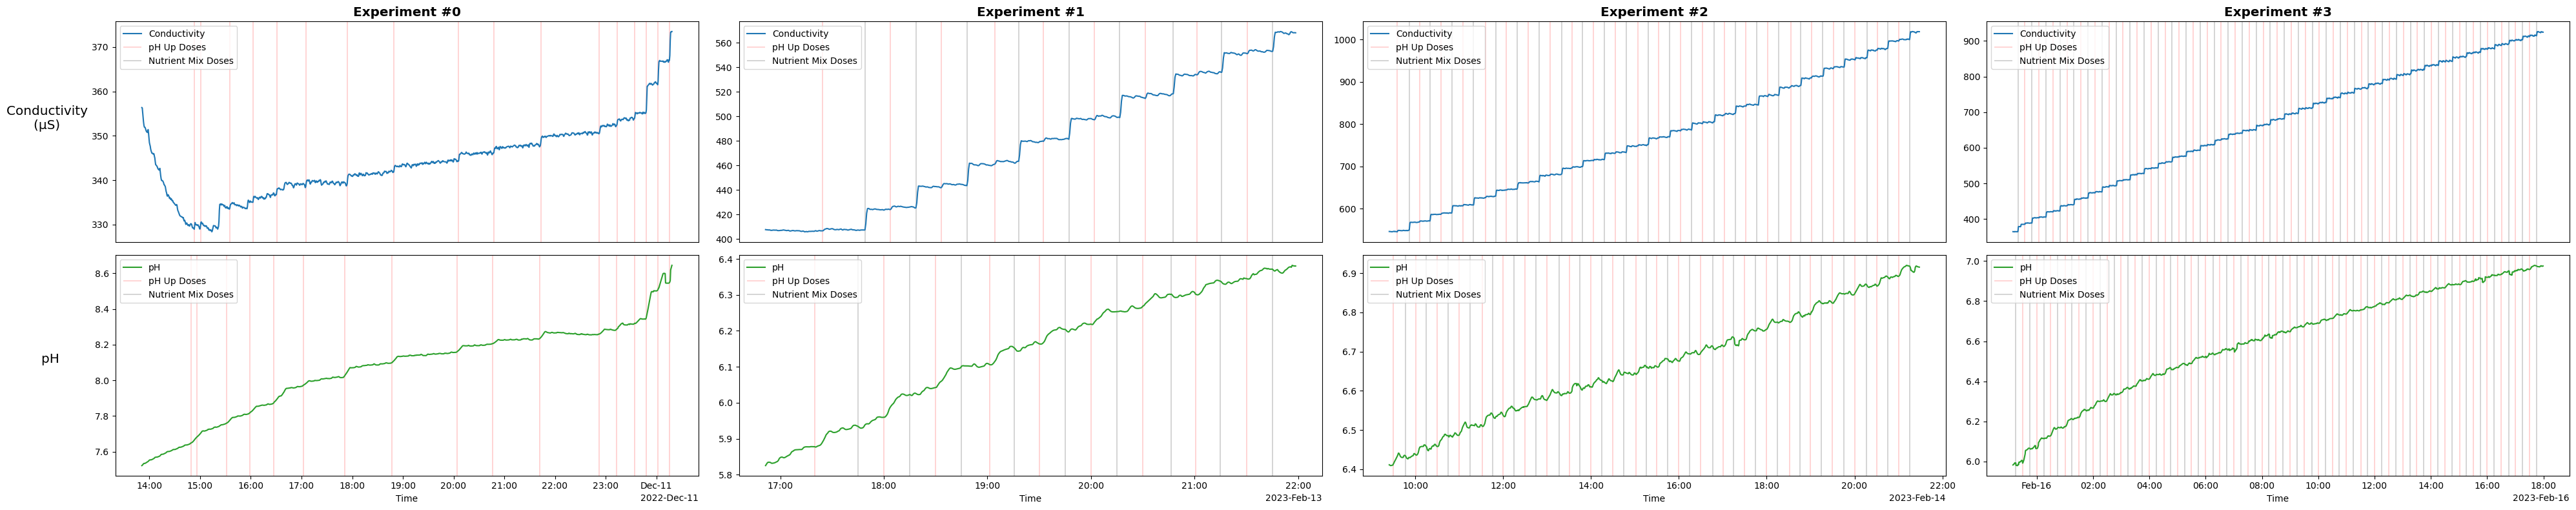

In [15]:
data_temp = data_all.reset_index().set_index(['experiment_number', 'Time'])
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(40, 8))
axs_idx = ((0, 4), (1, 5), (2, 6), (3, 7))
for exp_num in range(0, 4):
    ax1 = axs.flatten()[axs_idx[exp_num][0]]
    ax2 = axs.flatten()[axs_idx[exp_num][1]]
    plot_ec_and_ph(data_temp.loc[exp_num], axs=(ax1, ax2))
    
    ax1.set_title(f'Experiment #{exp_num}', weight='bold', size='x-large')
    ax1.set_xticks(ticks=[])
    
    ax2.set_title('')
    
    if exp_num == 0:
        ax1.set_ylabel('Conductivity                    \n(\u03bcS)                    ', rotation=0, ha='center', size='x-large') # I have bad habits
        ax2.set_ylabel('pH                    ', rotation=0, ha='center',  size='x-large')
    else:
        ax1.set_ylabel('')
        ax2.set_ylabel('')

plt.tight_layout()
plt.show()

Since we are interested in how the different additives affect the Conductivity, I prepared the graphs of Conductivity and pH (smoothed via rolling average) above with the pH Up and Nutrient Mix doses marked as vertical lines colored red and black, respectively. I included the pH for curiosity, but we are really interested in the Conductivity, so let's dig in.

Considering the plot of the first experiment where the only additive was pH Up, we can see that there is a clear and consistent increase in Conductivity after each dose. However, when analyzing the rest of the plots, this effect appears dwarfed by that of the Nutrient Mix doses. This is promising for our application, since it means that most of the Conductivity being contributed from additives is coming from the Nutrient Mix, the additive for which we want to use Conductivity as a proxy measurement in the first place.

We'll want to get a closer look at how those differences are distributed, but first we have some time-series issues to consider.

## Time-Series Analysis: A Digression

As made obvious from the Conductivity and pH plots above, both properties appear to increase steadily throughout the experiment due to the experimental design. In the context of time-series analysis, this is trait is referred to as **trending** and means our data is **non-stationary**, which will cause problems when modeling. To correct for this, we use a technique called **first-differencing**, or just **differencing**. Differencing de-trends a series by taking the value at `t` and subtracting the value at `t-w`, where `w` is a preset time interval, effectively capturing the point-to-point changes in the data while maintaining its **stationarity**.

Something else to consider is the time it takes for one property to respond to changes in another. Since we are trying to predict what will happen *next*, we need to be able to connect what's happening *now* with what happened *before*. We can do this by calculating the "before" variable's **lag**, being simply the value for that variable at `t-w`.

For our time-series analysis of the effect of additive Doses on Conductivity we want to find an answer to the question, "How big is the *change* in Conductivity *after* we add a Dose?" Framing the question in this way makes it clear that we need to calculate the **difference** of the Conductivity and the **lag** of the Dosage. 

But what should the values of `w` be, respectively, for these calculations? Below, we find out.

## Lag / Diff grid

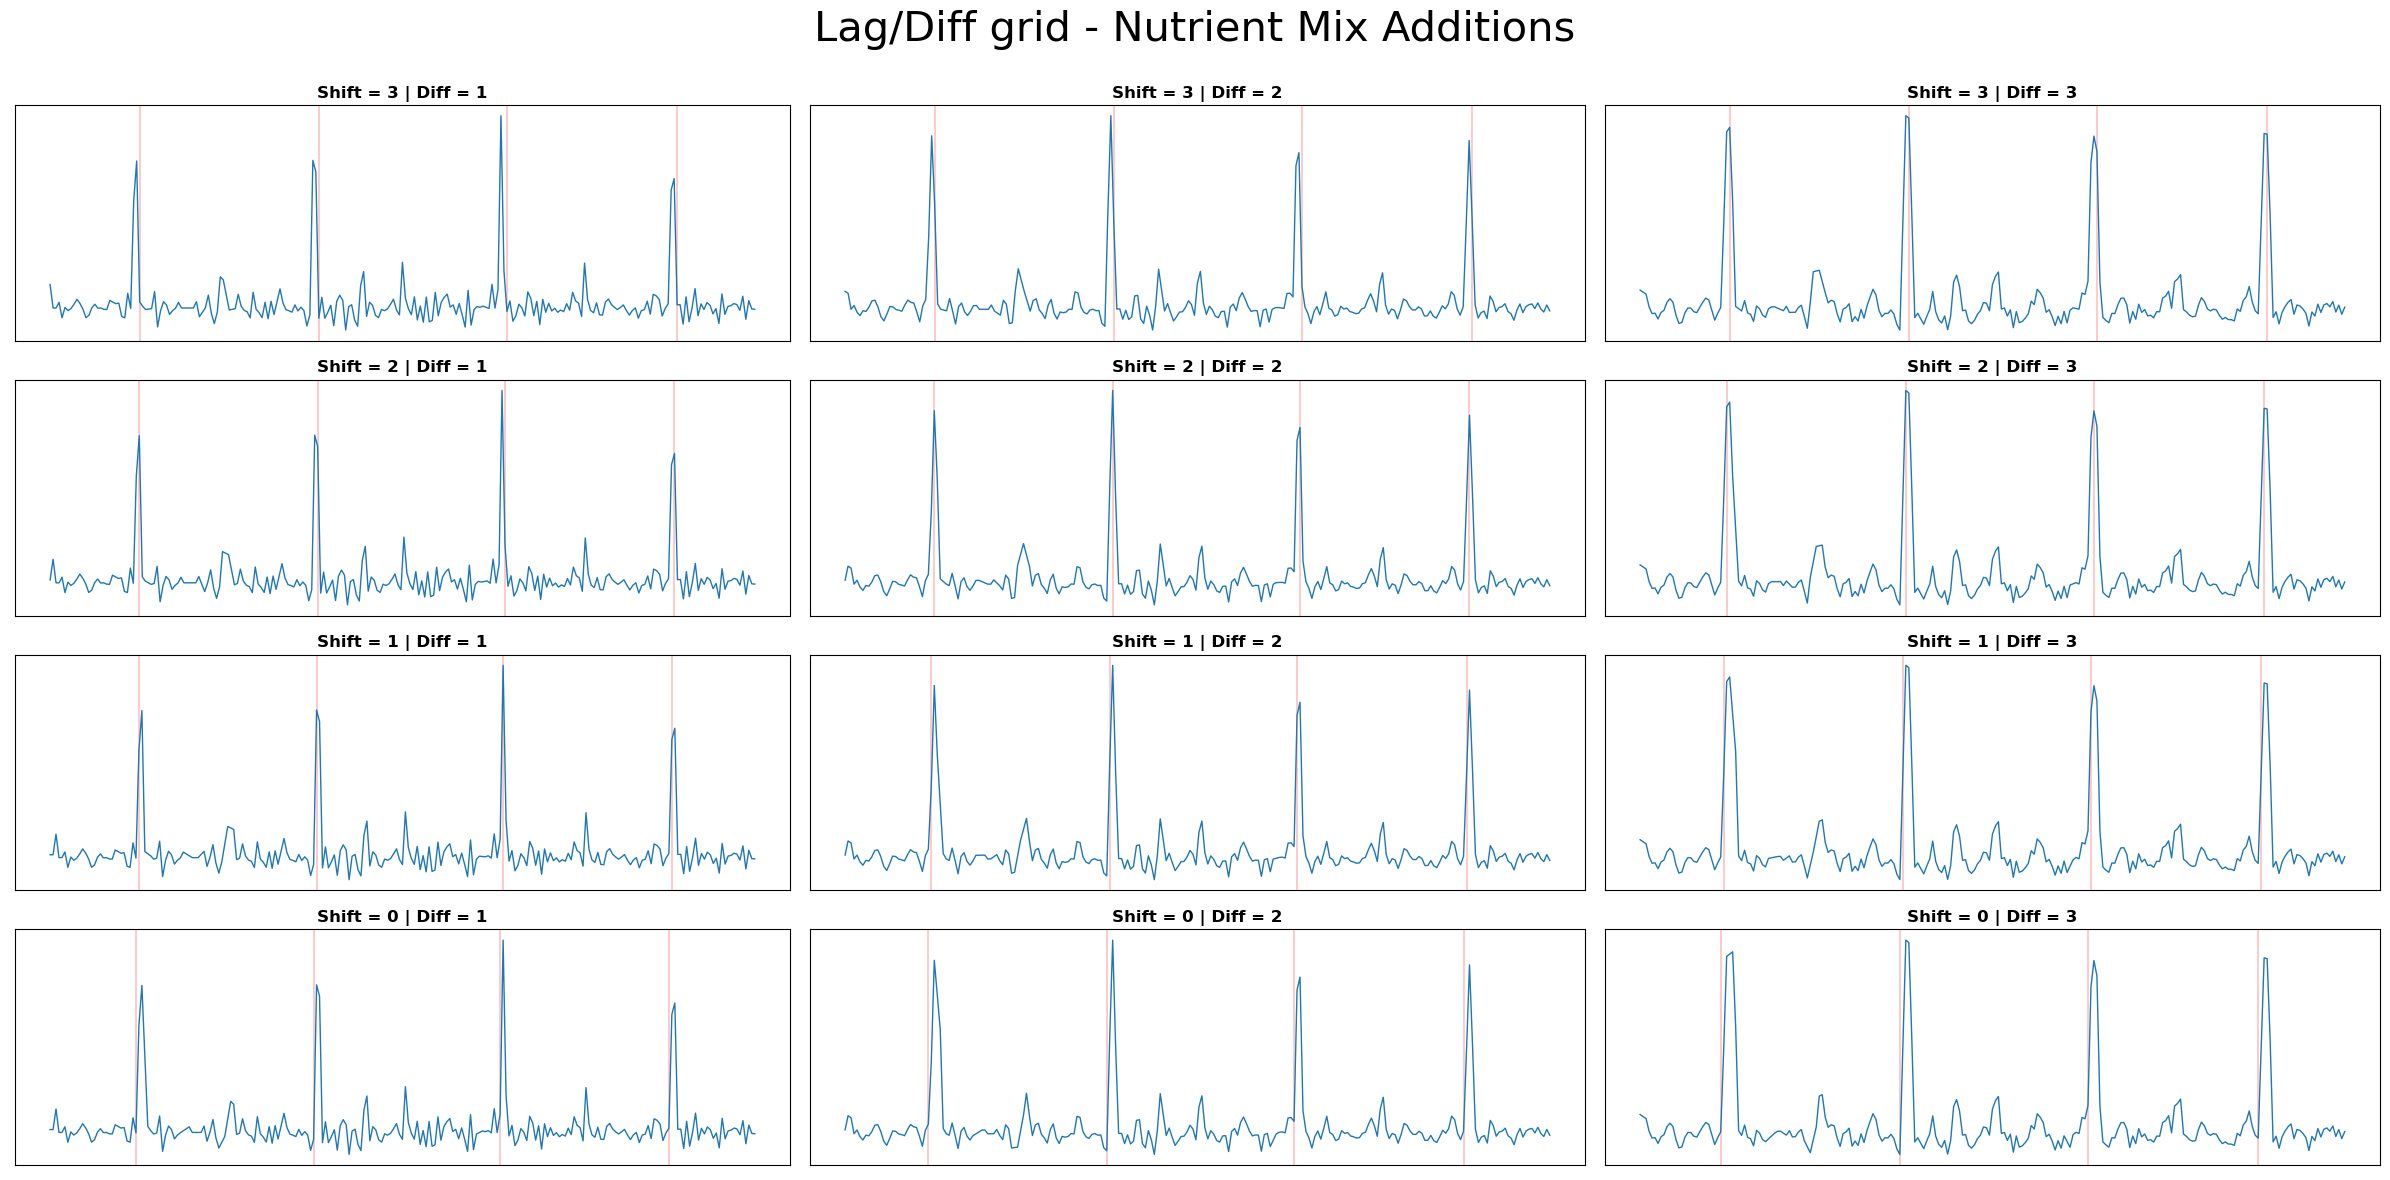

In [16]:
data = data_all.loc['2023-02-14 12':'2023-02-14 13']
nm_doses = np.array(data[~data.Nutrient_Mix_Dosing.isna() & data.Nutrient_Mix_Dosing!=0].index)

shifts = (-3, -2, -1, 0)
diffs = (1, 2, 3)
nrows = len(shifts)
ncols = len(diffs)
fig, axs = plt.subplots(nrows, ncols, figsize=(8*ncols, 3*nrows), dpi=100)
fig.suptitle('Lag/Diff grid - Nutrient Mix Additions', size=30)

for i, shift in enumerate(shifts):
    for j, diff in enumerate(diffs):
        ax = axs[i, j]
        ax.plot(data.Conductivity.diff(diff).shift(shift), label='EC Diff', lw=1)
        ph_ymin, ph_ymax = ax.get_ylim()
        ax.set_ylim(ax.get_ylim())
        ax.vlines(x=nm_doses, ymin=ph_ymin, ymax=ph_ymax, 
                       colors='red', lw=.3, label='pH Up Additions')
        
        ax.set_title(f'Shift = {shift*-1} | Diff = {diff}', weight='bold')
        ax.set_xticks([])
        ax.set_yticks([])


plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

Above is a matrix showing a subset of the differenced Conductivity (hereafter referred to as `ec_diff`) and lagged Nutrient Mix Doses, with the columns being different `w` values for the difference calculation, and the rows being the same for the lag calculation. The idea here is to find the smallest difference value that still allows the doses to always line up, and the lag value that most consistently hits all of the peaks.

To my eye, the best value for both calculations is 2 - since our data is sampled to 30 second intervals, a window value of 2 corresponds to 1 minute. This is what we will use moving forward.

### Source Data Prep for Time-Series
Pandas dataframes have convenience methods for calculating both of these time-series columns (`diff()` and `shift()`) that we make use of below. We calculate `ec_diff` and `_lag` variables for Dosing events as well as any other variable that might be used as a predictor in our modeling.

In [17]:
import warnings
warnings.simplefilter('ignore')

# set optimal lag and diff parameters determined above
shift = 2
diff = 2

data = data_all[['pH_Up_Dosing', 'Conductivity', 'pH', 
                 'Scale Reading', 'Water Temp', 'cumulative_ph_up', 
                 'Nutrient_Mix_Dosing', 'cumulative_nutrient_mix', 
                 'humidity', 'room_temp', 'water_amount']]

data.pH_Up_Dosing.fillna(0, inplace=True)
data.Nutrient_Mix_Dosing.fillna(0, inplace=True)

# Add calculated column which answers the question:
## What's the Conductivity now versus {diff} readings ago?
data['ec_diff'] = data.Conductivity.diff(diff)

# Add calculated column for dosing events lagged by {shift} readings
for col in ('pH_Up_Dosing', 'Nutrient_Mix_Dosing', 
            'Water Temp', 'room_temp', 'humidity', 'pH'):
    lag_col_name = col + '_lag'
    data[lag_col_name] = data[col].shift(shift)

# data['pH_Up_Dosing_lag'] = data.pH_Up_Dosing.shift(shift)
# data['Nutrient_Mix_Dosing_lag'] = data.Nutrient_Mix_Dosing.shift(shift)

# Non-continuous data messes up the diff calculation for the first datapoints
# in every exp. These are easily filtered out.
data = data[data.ec_diff > -100]
warnings.simplefilter('default')

data.describe()

,pH_Up_Dosing,Conductivity,pH,Scale Reading,Water Temp,cumulative_ph_up,Nutrient_Mix_Dosing,cumulative_nutrient_mix,humidity,room_temp,water_amount,ec_diff,pH_Up_Dosing_lag,Nutrient_Mix_Dosing_lag,Water Temp_lag,room_temp_lag,humidity_lag,pH_lag
count,5573.0000,5573.0000,5573.0000,1265.0000,5573.0000,5573.0000,5573.0000,5573.0000,4308.0000,4308.0000,4308.0000,5573.0000,5573.0000,5573.0000,5573.0000,4306.0000,4306.0000,5573.0000
mean,0.2014,600.0867,6.8971,72.3886,23.7875,216.0534,0.1911,201.6005,52.0217,21.8467,12.6927,0.4385,0.2014,0.1911,23.7892,21.8471,52.0121,6.8969
std,1.6988,203.5769,0.6898,0.5977,1.3730,170.0370,1.6824,177.2735,4.6774,0.5249,26.1610,2.3426,1.6988,1.6824,1.3760,0.5248,4.6572,0.6901
min,0.0000,328.1000,5.7982,71.0967,-12.2624,0.0000,0.0000,0.0000,37.2000,20.5000,-1572.9450,-22.0084,0.0000,0.0000,-12.2624,20.5000,37.2000,5.7982
25%,0.0000,405.7000,6.4524,72.2883,23.0120,53.5714,0.0000,0.0000,48.9044,21.3500,13.7306,-0.3970,0.0000,0.0000,23.0113,21.3506,48.9015,6.4508
50%,0.0000,589.4158,6.7009,72.3120,23.2712,180.0000,0.0000,180.0000,52.4148,21.9345,14.1687,-0.0412,0.0000,0.0000,23.2712,21.9345,52.4138,6.7007
75%,0.0000,778.8667,6.9493,72.3500,24.5300,360.0000,0.0000,360.0000,54.2661,22.3000,17.9200,0.4071,0.0000,0.0000,24.5300,22.3000,54.2585,6.9493
max,15.0000,1019.0000,8.7060,79.5820,28.5300,570.0000,15.0000,570.0000,72.8200,22.7818,18.9400,34.2647,15.0000,15.0000,28.5300,22.7818,72.7000,8.7060


## Plotting Distribution of `ec_diff` By Additive Dose

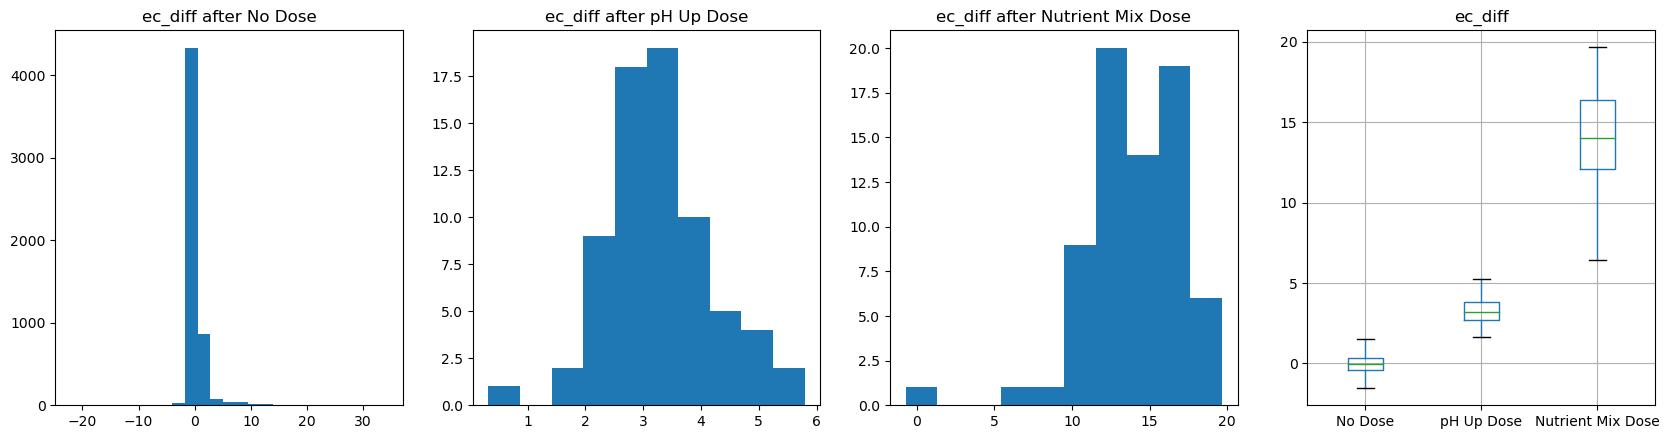

In [18]:
data_dist = data[(data.pH_Up_Dosing_lag==0.0)|(data.pH_Up_Dosing_lag==15.0)]

fig, axs = plt.subplots(ncols=4, figsize=(20,5))
no_dose = ((data_dist.Nutrient_Mix_Dosing_lag == 0) & (data_dist.pH_Up_Dosing_lag == 0))
nm_dose = data_dist.Nutrient_Mix_Dosing_lag != 0
ph_up_dose = data_dist.pH_Up_Dosing_lag != 0

axs[0].hist(data_dist[no_dose].ec_diff, bins=25)
axs[0].set_title('ec_diff after No Dose')

axs[1].hist(data_dist[ph_up_dose].ec_diff)
axs[1].set_title('ec_diff after pH Up Dose')

axs[2].hist(data_dist[nm_dose].ec_diff)
axs[2].set_title('ec_diff after Nutrient Mix Dose')

data_dist.boxplot(column='ec_diff', by=['Nutrient_Mix_Dosing_lag', 'pH_Up_Dosing_lag'], ax=axs[3], showfliers=False)
axs[3].set_xticks((1, 2, 3))
axs[3].set_xticklabels(('No Dose', 'pH Up Dose', 'Nutrient Mix Dose'))
axs[3].set_xlabel('')

fig.suptitle('')

plt.show()

In [19]:
data_dist.groupby(['Nutrient_Mix_Dosing_lag', 'pH_Up_Dosing_lag']).ec_diff.describe().T

Nutrient_Mix_Dosing_lag   0.0000          15.0000
pH_Up_Dosing_lag          0.0000  15.0000 0.0000 
count                   5415.0000 70.0000 71.0000
mean                       0.2215  3.2862 13.9952
std                        1.7117  0.9259  3.2465
min                      -22.0084  0.3226 -0.6944
25%                       -0.4054  2.6969 12.0722
50%                       -0.0639  3.1874 14.0072
75%                        0.3594  3.7851 16.3744
max                       34.2647  5.7917 19.6644

The histograms, boxplots, and summary above confirm what we suspected before: Nutrient Mix has a much bigger on Conductivity (mean `ec_diff` of about 14) than pH_Up (mean about 3).

Below, I will apply machine learning to try to get a more exact description of these relationships as part of the larger system. 

# Modeling

Unfortunately, the data we have doesn't allow us to directly model how much each component contributes to the current Conductivity. However, we can predict how much the *next* addition will be, and the changes we see are consistent enough that we can still get a crude idea of how the Conductivity is composed.

Having said that, let's get into the models! We will be applying the following regression algorithms:
- Least Squares Regression
- Decision Tree Regression
- Random Forest Regression
- Gradient Boosted Regression
- K-Neighbors Regression

I chose these models because they provide a nice mix of parametric vs. non-parametric, bagging and boosting, and a general variety in approaches. For each of these algorithms, we will fit the model on the default parameters and, if applicable, will improve the model with manual hyperparameter tuning and/or an automated GridSearch approach. We will score the models using the helper function defined and explained below.

In [20]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn import metrics

### Helper Functions
Since this is a time-series analysis, the usual TrainTestSplit approach won't work. Instead, we will use a method called **Forward-Chain Cross Validation**, in which the splits are applied and tested sequentially. For example, if I had 4 years of data, and 4 splits, the first round of CV would train the model on Year 1 and test on Year 2. The next round, the training set would include both Years 1 and 2, and the test set is Year 3, and so on. Scikit-learn provides a convenient TimeSeriesSplit object to do this.

For this application, since our data is non-continuous and the first sequential dataset is distinctly different from the others in design, I decided to be a bit generous with the scoring. I defined 12 splits, but when considering the score I threw out the first 6, averaging the last 6 CV scores. This process is contained in the function below.

In [21]:
# helper function to evaluate regression
def regression_score(model, model_str, X, y):
    tscv = TimeSeriesSplit(n_splits=12)
    r2 = cross_val_score(model, X, y, scoring='r2', cv=tscv)[-6:].mean()
    mse = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=tscv)[-6:].mean() * -1
    rmse = np.sqrt(mse)
    
    scores = {
        'R2': r2,
        'MSE' : mse,
        'RMSE' : rmse
    }
    
    return pd.DataFrame(scores, index=[model_str])

### Define data subset

In [22]:
X_columns = ['pH_lag', 
             'Water Temp_lag', 
             'pH_Up_Dosing_lag', 
             'Nutrient_Mix_Dosing_lag']

X = data[X_columns]
y = data.ec_diff

In [23]:
scores_tracker = []

## Model: Linear Regression

In [24]:
ols = LinearRegression()
scores = regression_score(ols, 'OLS', X, y)
display(scores)
ols.fit(X, y)
display(pd.Series(ols.coef_, index=X.columns))
scores_tracker.append(scores)

,R2,MSE,RMSE
OLS,0.4973,2.8362,1.6841


pH_lag                     0.0237
Water Temp_lag            -0.0901
pH_Up_Dosing_lag           0.2043
Nutrient_Mix_Dosing_lag    0.9151
dtype: float64

Given that our input data is not normally distributed, I did not expect much out of OLS regression. However it seems we have a relatively decent approximation despite that fact, with an R2 of 0.497. Our coefficients also make sense; a value of 0.915 for Nutrient Mix Dosing lines up with our earlier observation of an average ec_diff of 14 for that additive, since our usual dose is 15mL. Likewise, the coefficient of .204 for pH Up Dosing lines up with an average ec_diff of 3 for a 15 mL dose.

Next, let's try some non-parametric models.

## Model: Decision Tree Regressor

In [25]:
dt = DecisionTreeRegressor()
scores = regression_score(dt, 'Decision Tree Default', X, y)
display(scores)
scores_tracker.append(scores)

,R2,MSE,RMSE
Decision Tree Default,-0.1598,6.0561,2.4609


Default model is pretty bad! Time for some tuning and pruning. We set max depth and some splitting limitations to keep the tree from overfitting.

In [26]:
dt = DecisionTreeRegressor(max_depth=5, min_samples_split=.01, min_samples_leaf=10)
scores = regression_score(dt, 'Decision Tree Manual Tune', X, y)
display(scores)
scores_tracker.append(scores)

,R2,MSE,RMSE
Decision Tree Manual Tune,0.4882,2.8940,1.7012


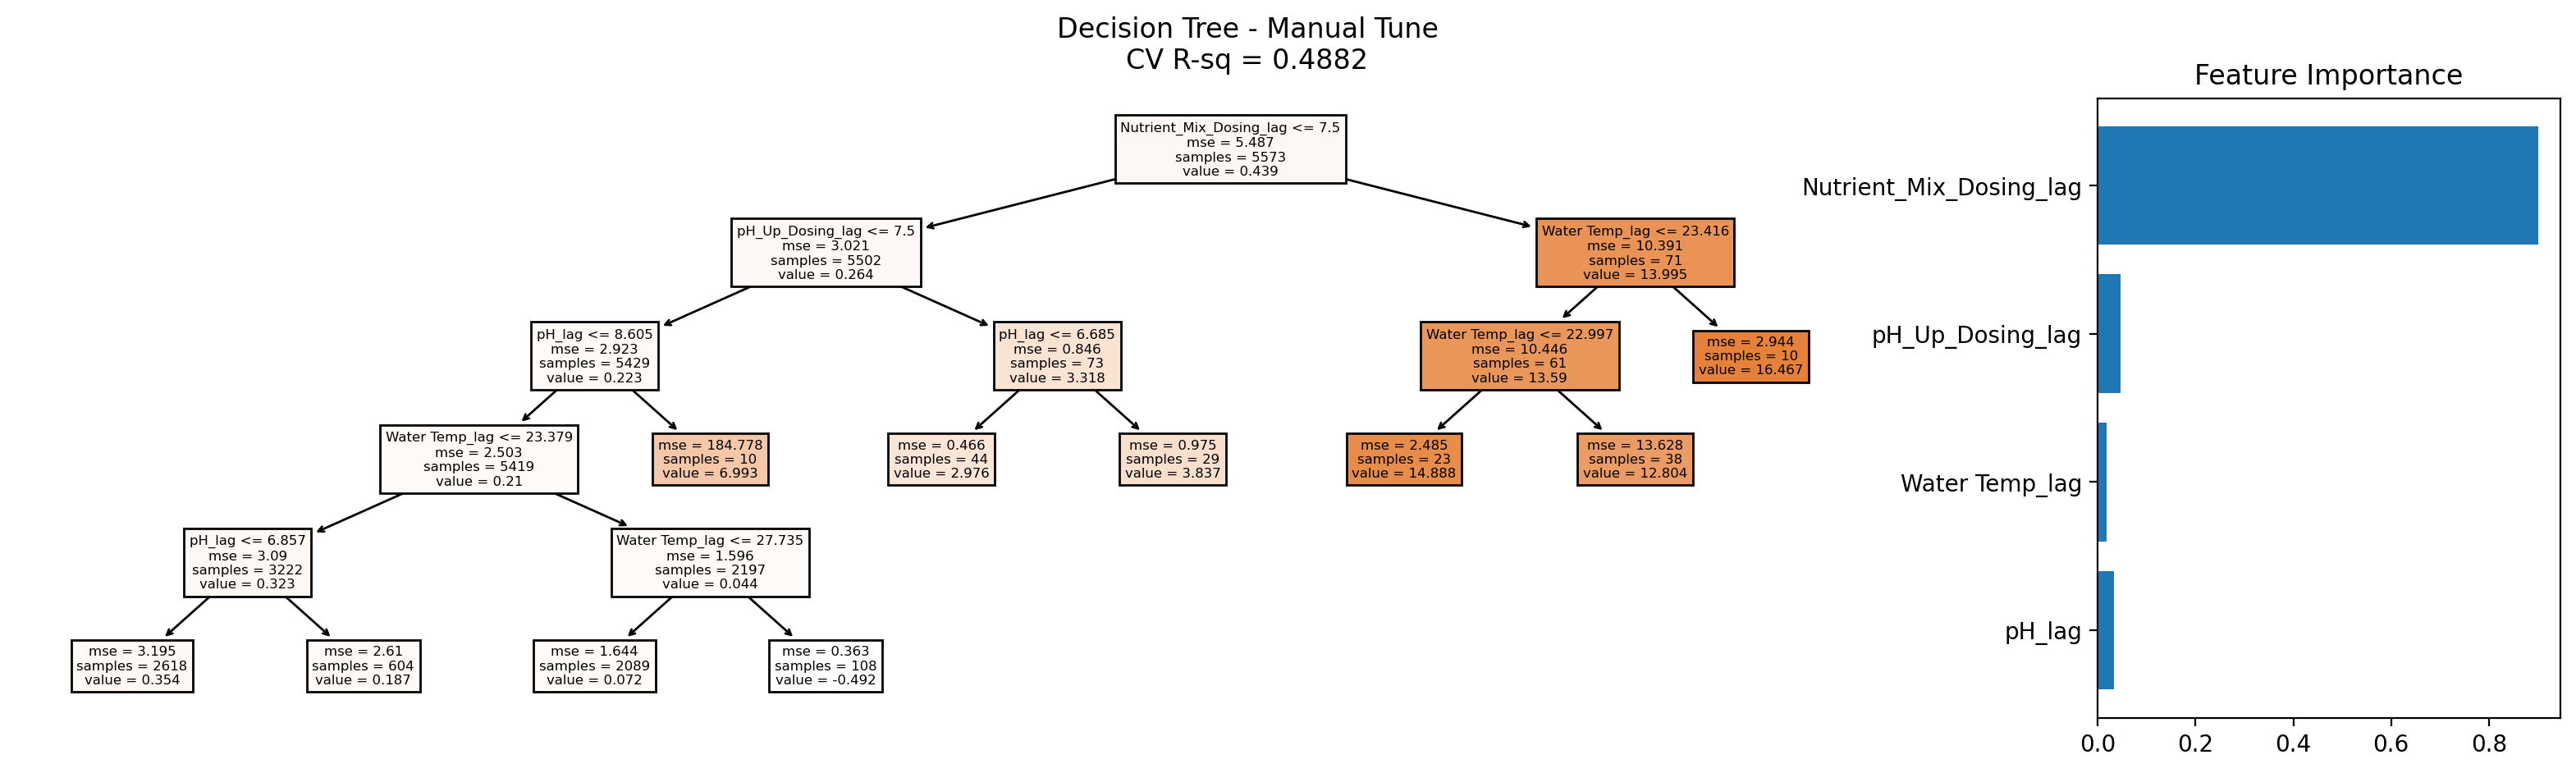

In [27]:
score = scores['R2'][0]
dt.fit(X, y)
fig = plt.figure(figsize=(20, 5), dpi=200)
gs = GridSpec(nrows=1, ncols=2, width_ratios=[4, 1])

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

plot_tree(dt, ax=ax0, filled=True, feature_names=X_columns)
ax1.barh(y=X_columns, width=dt.feature_importances_)
fig.suptitle(f'Decision Tree - Manual Tune\nCV R-sq = {score:.4}')
ax1.set_title('Feature Importance')

plt.show()

Better! Not quite as high scoring as the OLS model, but close enough. As expected, Nutrient Mix Dosing is the most important feature by far. Let's see if  we can improve it even more.

In [28]:
dt2 = DecisionTreeRegressor()
param_grid = {
    'max_depth': [2, 3, 4, 5, 6],
    'min_samples_split': [.001, .01, .1],
    'min_samples_leaf': [5, 10, 50]
}

dt_gscv = GridSearchCV(dt2, param_grid, scoring='r2', n_jobs=-2).fit(X, y)
print('GridSearch Best Params:\n')
print(pd.Series(dt_gscv.best_params_))
print(f'\nR2 Score: {dt_gscv.best_score_:.3}')

GridSearch Best Params:

max_depth            5.0000
min_samples_leaf    50.0000
min_samples_split    0.0010
dtype: float64

R2 Score: 0.369


In [29]:
dt = dt_gscv.best_estimator_
scores = regression_score(dt, 'Decision Tree GridSearchCV', X, y)
display(scores)
scores_tracker.append(scores)

,R2,MSE,RMSE
Decision Tree GridSearchCV,0.1460,4.8778,2.2086


Since our CV is based on time-series splits, the normal GridSearch doesn't seem to work. There is a way to natively incorporate the time-series split into the `GridSearchCV` function, but for the time being I will just use the nested loop coded below to accomplish the task of optimizing the `max_depth` and `min_samples_split` parameters.

,max_depth,min_samples_split,R2,MSE,RMSE
Decision Tree My GridSearch,3,0.0500,0.4985,2.8365,1.6842


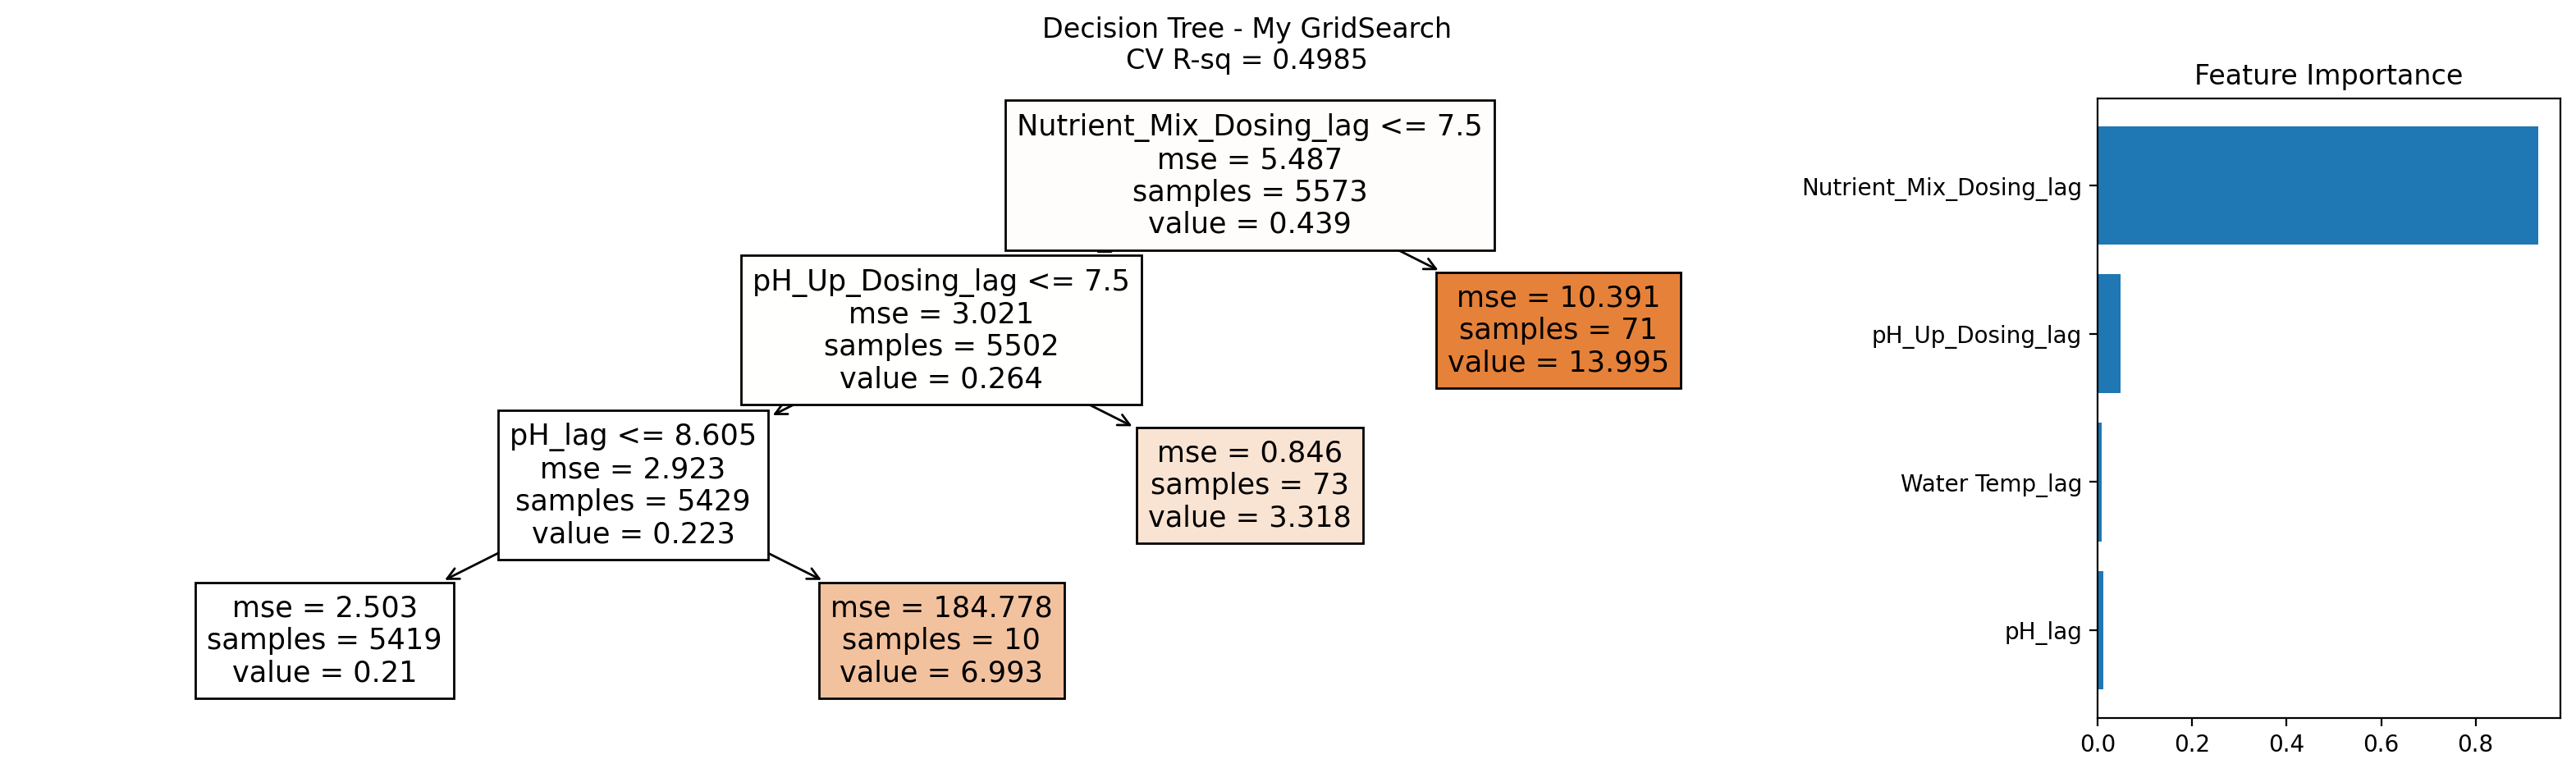

In [30]:
dt_scores = pd.DataFrame(columns=['max_depth', 'min_samples_split', 'R2', 'MSE', 'RMSE'])
model_num = 0
for max_depth in range(2, 6):
    for min_samples_split in (.001, .005, .01, .05, .1):
        model_num += 1
        dt3 = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=10)
        score = regression_score(dt3, 'Decision Tree My GridSearch', X, y)
        score['max_depth'] = [max_depth]
        score['min_samples_split'] = min_samples_split
        dt_scores = pd.concat((dt_scores, score))

scores = dt_scores.sort_values(by='R2', ascending=False).head(1)
display(scores)
scores_tracker.append(scores)

dt3 = DecisionTreeRegressor(max_depth=3, min_samples_split=.05, min_samples_leaf=10)
score = scores['R2'][0]
dt3.fit(X, y)
fig = plt.figure(figsize=(20, 5), dpi=200)
gs = GridSpec(nrows=1, ncols=2, width_ratios=[4, 1])

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

plot_tree(dt3, ax=ax0, filled=True, feature_names=X_columns)
ax1.barh(y=X_columns, width=dt.feature_importances_)
ax1.set_title('Feature Importance')
fig.suptitle(f'Decision Tree - My GridSearch\nCV R-sq = {score:.4}')

plt.show()

Decent! We managed to top our R2 frontrunner with the relatively simplistic model above.

Next we will try a few ensemble models. I will apply the same general principles as above, and will hold commentary until after the next two sections.

## Model: Random Forest

In [31]:
rf = RandomForestRegressor()
scores = regression_score(rf, 'Random Forest Default', X, y)
display(scores)
scores_tracker.append(scores)

,R2,MSE,RMSE
Random Forest Default,0.4178,3.3476,1.8297


,R2,MSE,RMSE
Random Forest Manual Tune,0.4943,2.8618,1.6917


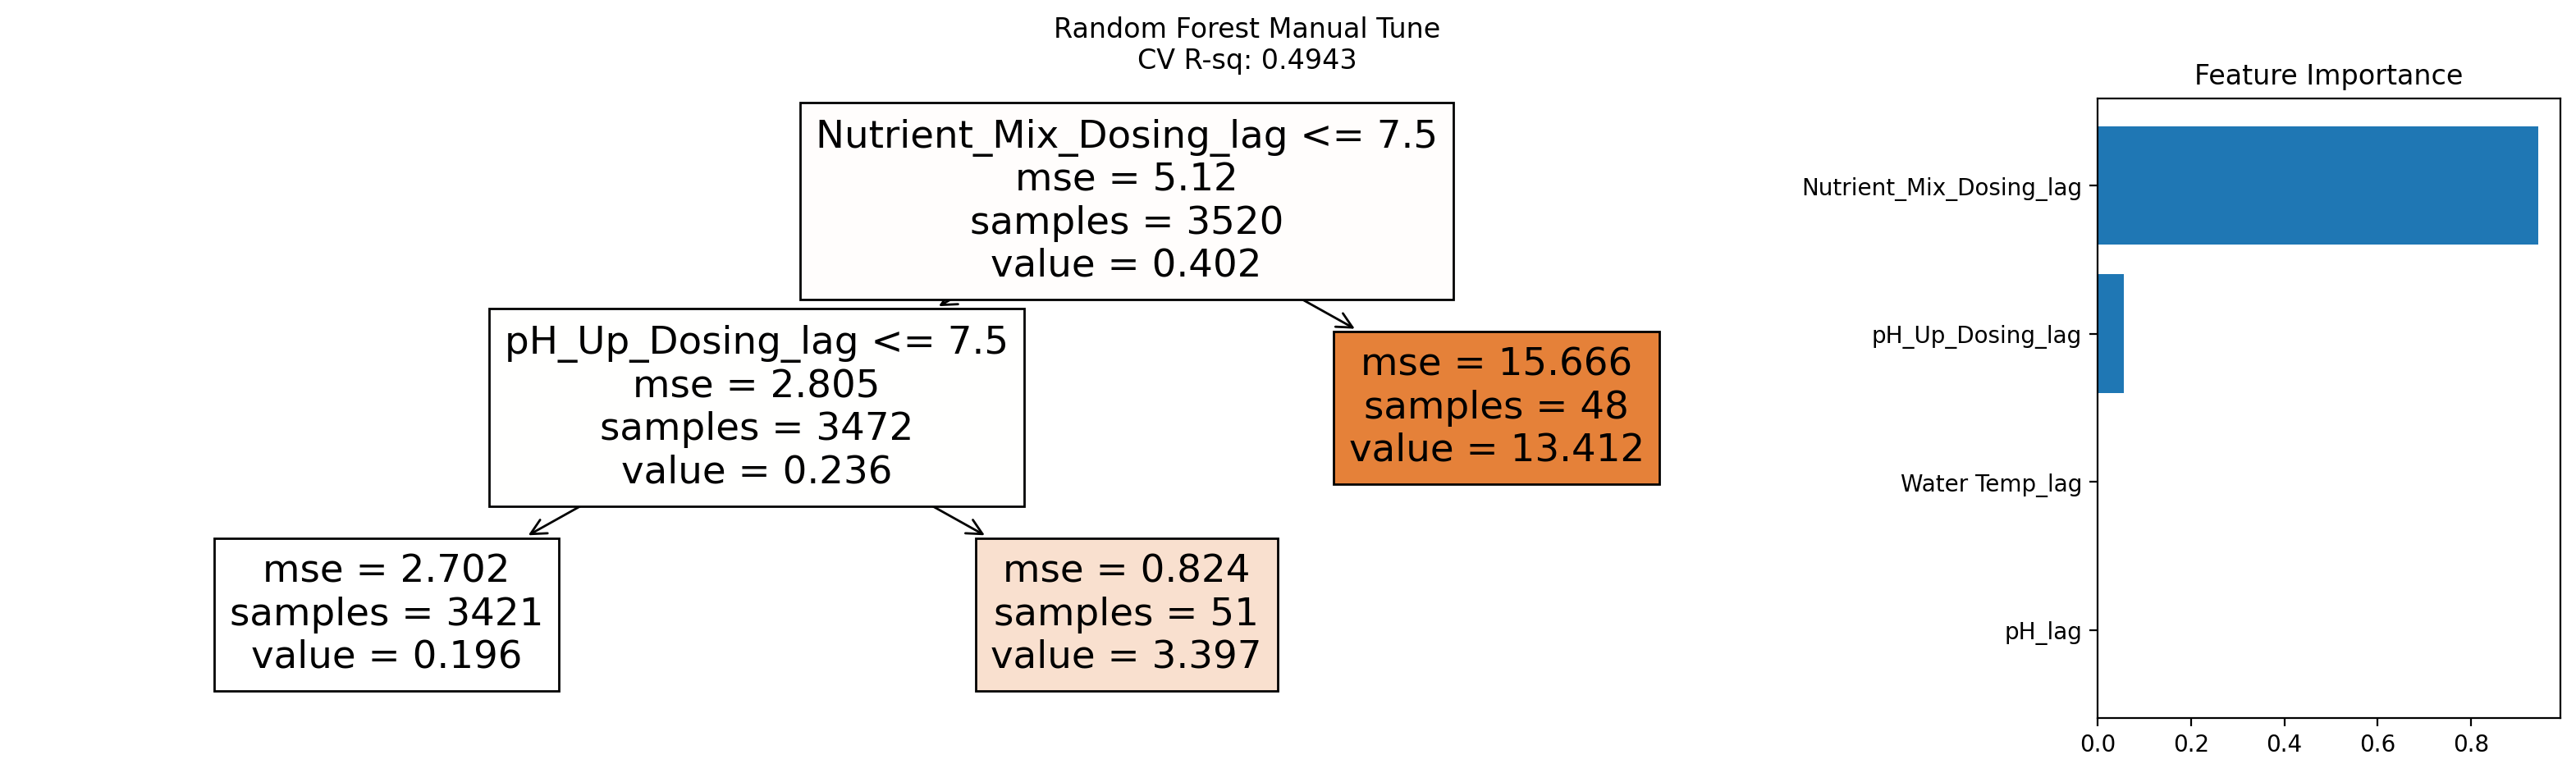

In [32]:
rf = RandomForestRegressor(max_depth=2, min_samples_split=.01, min_samples_leaf=10, n_jobs=-2, random_state=42)
scores = regression_score(rf, 'Random Forest Manual Tune', X, y)
display(scores)
scores_tracker.append(scores)

rf.fit(X, y)
score = scores['R2'][0]
rf_tree = rf.estimators_[0]
fig = plt.figure(figsize=(20, 5), dpi=200)
gs = GridSpec(nrows=1, ncols=2, width_ratios=[4, 1])

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

plot_tree(rf_tree, ax=ax0, filled=True, feature_names=X_columns)
ax1.barh(y=X_columns, width=rf_tree.feature_importances_)
fig.suptitle(f'Random Forest Manual Tune\nCV R-sq: {score:.4}')
ax1.set_title('Feature Importance')

plt.show()

In [33]:
rf_scores = pd.DataFrame(columns=['max_depth', 'min_samples_split', 'R2', 'MSE', 'RMSE'])
model_num = 0
for max_depth in range(2, 6):
    print(f'\nmax_depth = {max_depth}', end='')
    for min_samples_split in (.001, .005, .01, .05, .1):
        print('.', end='')
        model_num += 1
        rf = RandomForestRegressor(max_depth=max_depth, min_samples_split=min_samples_split, 
                                   n_estimators=25, min_samples_leaf=10, n_jobs=-2, random_state=42)
        
        score = regression_score(rf, 'Random Forest My GridSeach', X, y)
        score['max_depth'] = [max_depth]
        score['min_samples_split'] = min_samples_split
        rf_scores = pd.concat((rf_scores, score))

rf_scores.sort_values(by='R2', ascending=False).head(1)


max_depth = 2.....
max_depth = 3.....
max_depth = 4.....
max_depth = 5.....

,max_depth,min_samples_split,R2,MSE,RMSE
Random Forest My GridSeach,3,0.0100,0.4995,2.8312,1.6826


,R2,MSE,RMSE
Random Forest - My GridSearch,0.4993,2.8292,1.6820


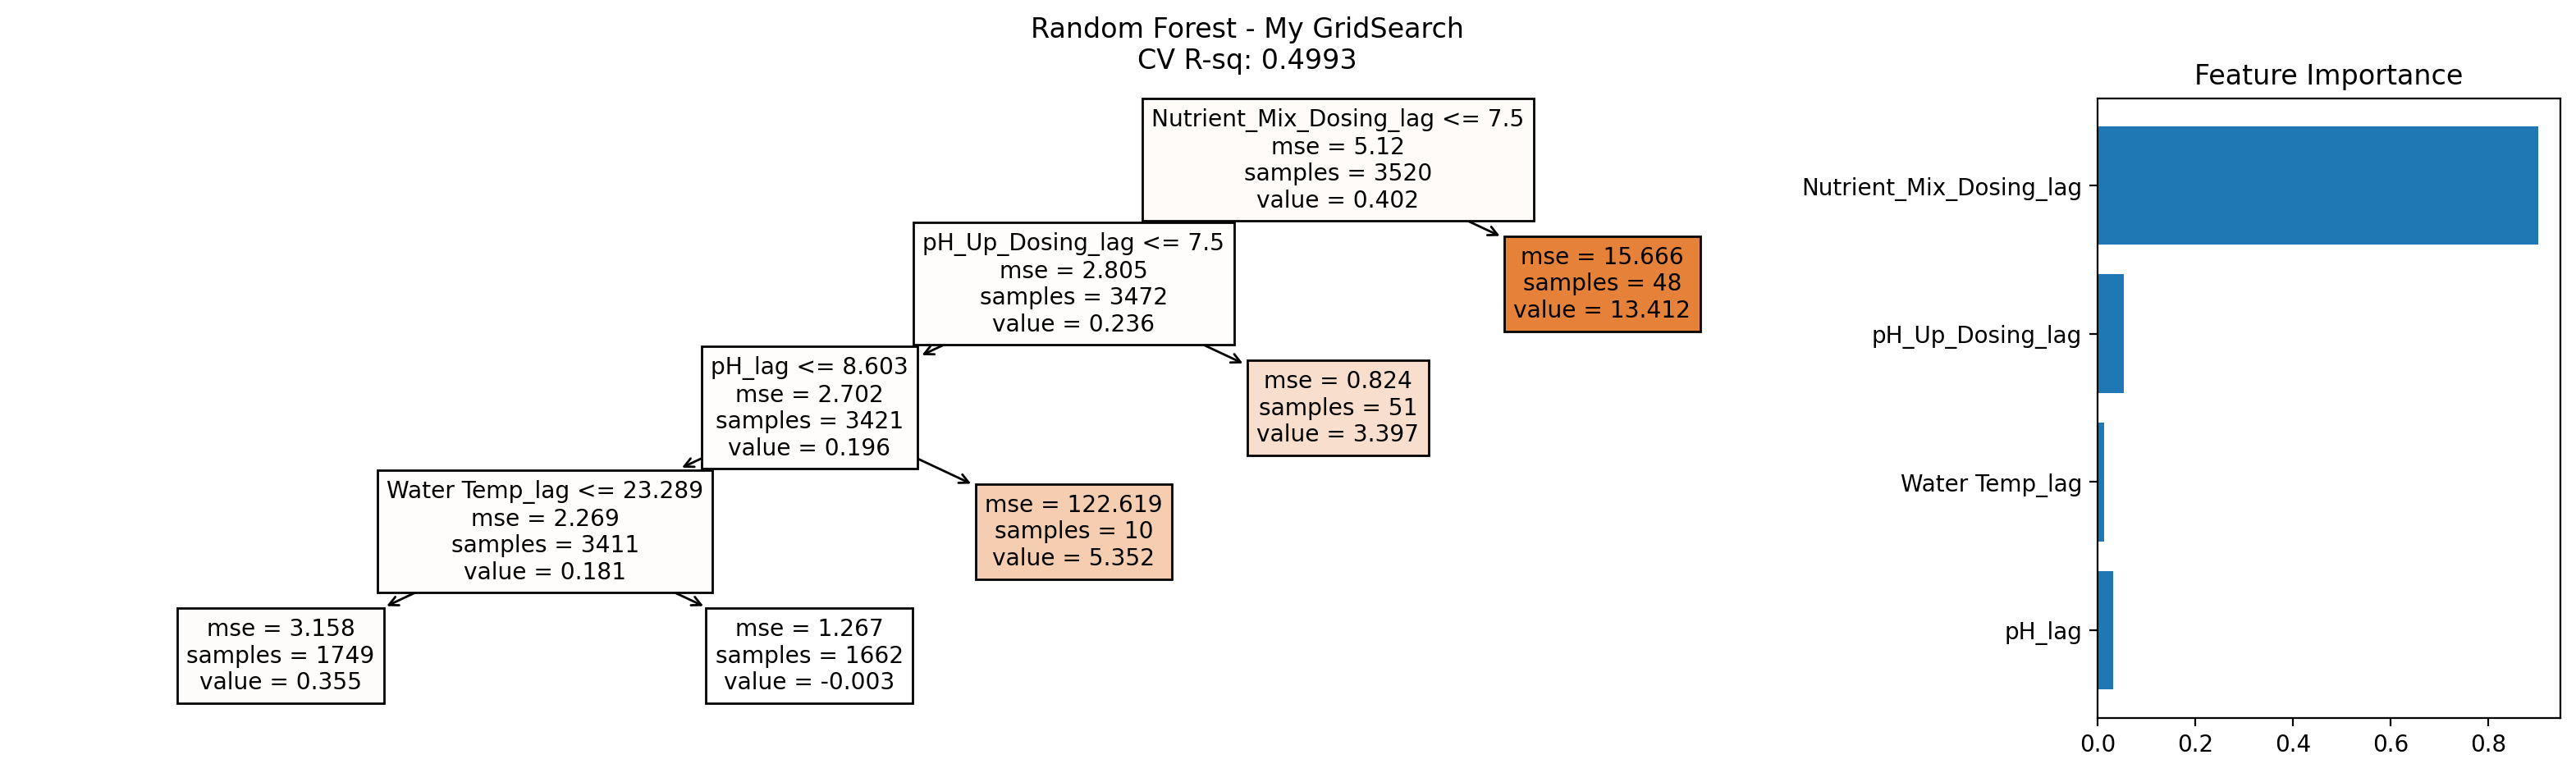

In [34]:
rf2 = RandomForestRegressor(max_depth=4, min_samples_split=.1, min_samples_leaf=10, n_jobs=-2, random_state=42, n_estimators=25)
scores = regression_score(rf2, 'Random Forest - My GridSearch', X, y)
display(scores)
scores_tracker.append(scores)

rf2.fit(X, y)
score = scores['R2'][0]
rf_tree = rf2.estimators_[0]
fig = plt.figure(figsize=(20, 5), dpi=200)
gs = GridSpec(nrows=1, ncols=2, width_ratios=[4, 1])

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

plot_tree(rf_tree, ax=ax0, filled=True, feature_names=X_columns)
ax1.barh(y=X_columns, width=rf_tree.feature_importances_)
fig.suptitle(f'Random Forest - My GridSearch\nCV R-sq: {score:.4}')
ax1.set_title('Feature Importance')

plt.show()

## Model: Gradient Boosting

In [35]:
gb = GradientBoostingRegressor()
scores = regression_score(gb, 'Gradient Boost Default', X, y)
display(scores)
scores_tracker.append(scores)

,R2,MSE,RMSE
Gradient Boost Default,0.4546,3.2903,1.8139


In [36]:
gb = GradientBoostingRegressor(learning_rate=.05, random_state=42, max_depth=2, min_samples_split=.1, min_samples_leaf=10)
scores = regression_score(gb, 'Gradient Boost Manual Tune', X, y)
display(scores)
scores_tracker.append(scores)

,R2,MSE,RMSE
Gradient Boost Manual Tune,0.5018,2.8185,1.6788


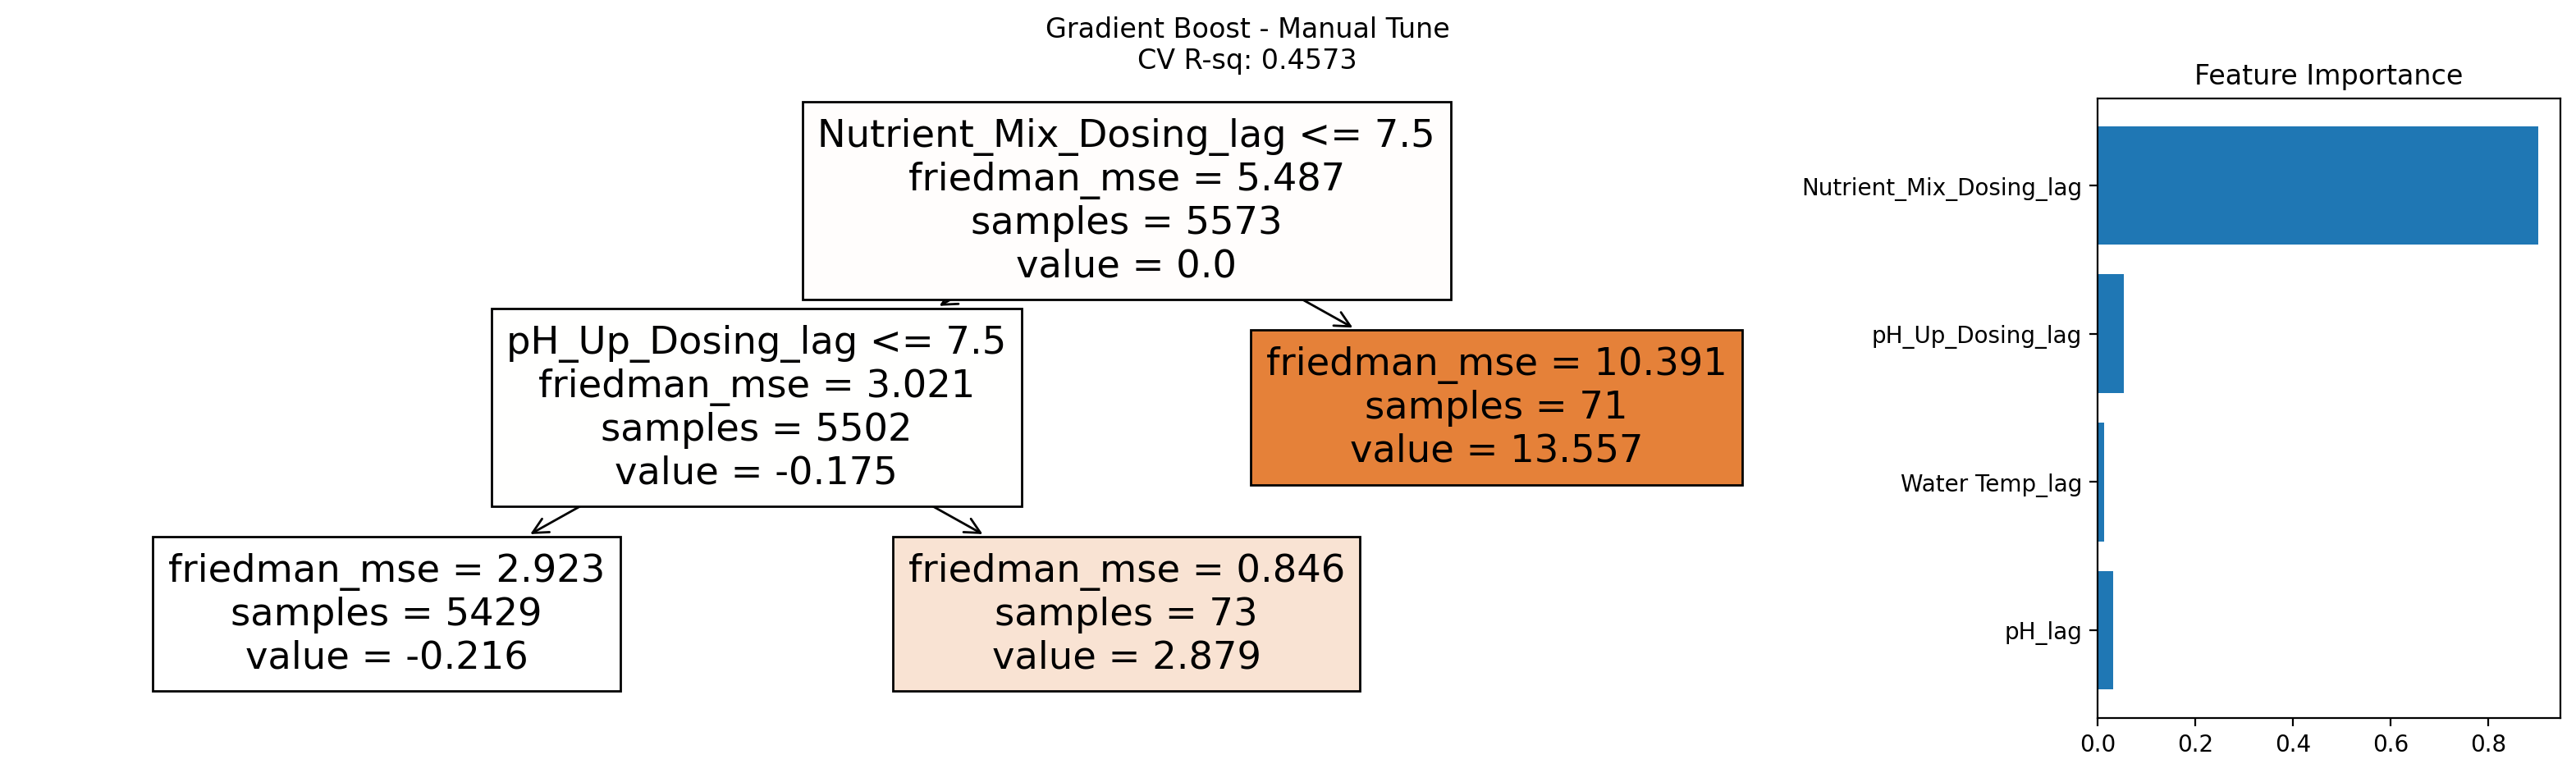

In [44]:
gb.fit(X, y)
score = scores['R2'][0]
gb_tree = gb.estimators_[0][0]
fig = plt.figure(figsize=(20, 5), dpi=200)
gs = GridSpec(nrows=1, ncols=2, width_ratios=[4, 1])

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

plot_tree(gb_tree, ax=ax0, filled=True, feature_names=X_columns)
ax1.barh(y=X_columns, width=rf_tree.feature_importances_)
fig.suptitle(f'Gradient Boost - Manual Tune\nCV R-sq: {score:.4}')
ax1.set_title('Feature Importance')

plt.show()

Looks like simplicity is king - of all these models, the one directly above is the best performer, with an R2 of 0.5018, and a depth of only 2. Of course, this is just one example tree in an ensemble model, but max_depth has been set to 2, so I do not expect much more complexity in any of the other trees in the Gradient Boosted model. This model, and the optimized Random Forest model above, agree with the previously built models about the Dosing effects.

Moving away from the trees, our final model will be the K-Neighbors Regressor.

## Model: K-Neighbors Regressor

In [38]:
knr = KNeighborsRegressor()
scores = regression_score(knr, 'KNR Default', X, y)
display(scores)
scores_tracker.append(scores)

,R2,MSE,RMSE
KNR Default,0.4573,3.0471,1.7456


Another decent start! Below, we execute a similar sort of grid-search optimization to try and improve the model by changing the `weight` parameter to distance, which should help quite a bit since our target `ec_diff` values are so distinctly far from the baseline. We also iterate over many possible values of k, specifying the number of neighbors to consider.

In [39]:
scores_u = []
scores_d = []
ks = range(1, 100)
for k in ks:
    if k % 10 == 0:
        print(f'{k}...')
    knr_u = KNeighborsRegressor(n_neighbors=k, weights='uniform')
    knr_d = KNeighborsRegressor(n_neighbors=k, weights='distance')
    scores_u.append(regression_score(knr_u, f'KNR Uniform k = {k}', X, y))
    scores_d.append(regression_score(knr_d, f'KNR Distance k = {k}', X, y))

10...
20...
30...
40...
50...
60...
70...
80...
90...


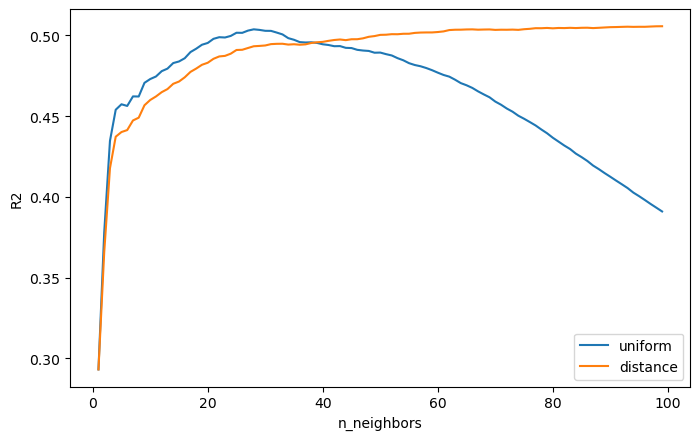

In [49]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(ks, pd.concat(scores_u)['R2'], label='uniform')
plt.plot(ks, pd.concat(scores_d)['R2'], label='distance')
plt.xlabel('n_neighbors')
plt.ylabel('R2')
plt.legend()
plt.show()

In [41]:
scores_tracker.append(pd.concat(scores_u).sort_values('R2', ascending=False).head(1))
scores_tracker.append(pd.concat(scores_d).sort_values('R2', ascending=False).head(1))

In [42]:
display(pd.concat(scores_u).sort_values('R2', ascending=False).head(1))
display(pd.concat(scores_d).sort_values('R2', ascending=False).head(1))

,R2,MSE,RMSE
KNR Uniform k = 28,0.5038,2.8231,1.6802


,R2,MSE,RMSE
KNR Distance k = 99,0.5057,2.8059,1.6751


## Final Comparison

In [43]:
pd.concat(scores_tracker, join='inner').sort_values('R2', ascending=False)

,R2,MSE,RMSE
KNR Distance k = 99,0.5057,2.8059,1.6751
KNR Uniform k = 28,0.5038,2.8231,1.6802
Gradient Boost Manual Tune,0.5018,2.8185,1.6788
Random Forest - My GridSearch,0.4993,2.8292,1.6820
Decision Tree My GridSearch,0.4985,2.8365,1.6842
OLS,0.4973,2.8362,1.6841
Random Forest Manual Tune,0.4943,2.8618,1.6917
Decision Tree Manual Tune,0.4882,2.8940,1.7012
KNR Default,0.4573,3.0471,1.7456
Gradient Boost Default,0.4546,3.2903,1.8139


Looks like our KNR models pulled into first and second place right at the end! Distance weighted and with a k of 99, we managed an R2 of 0.5057. Still not quite production ready, but it'll do for now.

As our models are all in general agreement on the general impact of both additives, I feel I can trust any addition of pH Up and Nutrient Mix will follow the `ec_diff` per mL given by the OLS coefficients in our very first model.